# A04: Model Interpretability (xAI)

# Name : vikram krishnareddy
# student id: 3220965

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install gdown -q
!gdown 1CppeqGbiBzX61jx56gcXyGGDNEeLlJ-W

Downloading...
From: https://drive.google.com/uc?id=1CppeqGbiBzX61jx56gcXyGGDNEeLlJ-W
To: /content/train_loan_imbalanced.csv
100% 38.0k/38.0k [00:00<00:00, 45.6MB/s]


In [4]:
# loading the dataset
df = pd.read_csv("train_loan_imbalanced.csv")

print("Shape of dataset:", df.shape)

df.head()

Shape of dataset: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 57.7+ KB


In [8]:
df.isna().sum()

,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14
Credit_History,50


# Cleaning  the Dataset

In [5]:
#  Preparing  data for modeling

# i am Droping the  Loan_ID since it is only an identifier and does not help in prediction
df = df.drop("Loan_ID", axis=1)

# Converting  Loan_Status from Y/N to 1/0 for binary classification
df["Loan_Status"] = df["Loan_Status"].map({"Y": 1, "N": 0})

print(df["Loan_Status"].value_counts())

Loan_Status
1    422
0    192
Name: count, dtype: int64


# Define Features and Split Data

In [6]:


# Separate independent variables (X) and target variable (y)
# X contains all predictors, y contains Loan approval outcome
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

# Spliting the  data into training and testing sets
# We use stratify=y to maintain the same class imbalance ratio in both training and testing datasets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.25, random_state=42, stratify=y)

# Verifying  dimensions after split
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

# Confirm class distribution is preserved
print("\nTraining class distribution:")
print(y_train.value_counts())

print("\nTesting class distribution:")
print(y_test.value_counts())

Training shape: (460, 11)
Testing shape: (154, 11)

Training class distribution:
Loan_Status
1    316
0    144
Name: count, dtype: int64

Testing class distribution:
Loan_Status
1    106
0     48
Name: count, dtype: int64


# data Preprocessing

In [9]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# First, identify numeric and categorical columns
# We need to treat them differently before modeling
num_cols = X_train.select_dtypes(include=["int", "float"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

# For numeric columns:
# Filling the  missing values using median (simple and works well for skewed data)
num_processor = SimpleImputer(strategy="median")

# For categorical columns:
# Filling the missing values using most frequent category
# Then convert categories into numeric format using one-hot encoding
cat_processor = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both preprocessing steps together
preprocess = ColumnTransformer([
    ("num", num_processor, num_cols),
    ("cat", cat_processor, cat_cols)
])

print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

Numeric columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


# Model + Grid Search

In [11]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42, class_weight="balanced")

clf = Pipeline([("prep", preprocess),("rf", model)])
param_grid = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [None, 5, 10],
    "rf__min_samples_split": [2, 10]
}

grid = GridSearchCV( clf,  param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1)

grid.fit(X_train, y_train)

print(" parameters:", grid.best_params_)
print("  ROC-AUC:", grid.best_score_)

 parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
  ROC-AUC: 0.7314813389436233


* Here, I built a Random Forest classifier and performed hyperparameter tuning using GridSearchCV.

* I evaluated different tree sizes and splitting rules. Since the dataset is imbalanced, I optimized using ROC-AUC instead of accuracy.
*  The best model achieved a cross-validated ROC-AUC of approximately 0.73

# Permutation Importance (Top 5 features with 20 repeats)

Top 5 features (permutation importance):
cat__Dependents_0: 0.2753
cat__Dependents_1: 0.0184
cat__Gender_Female: 0.0033
cat__Married_Yes: 0.0021
cat__Married_No: 0.0000


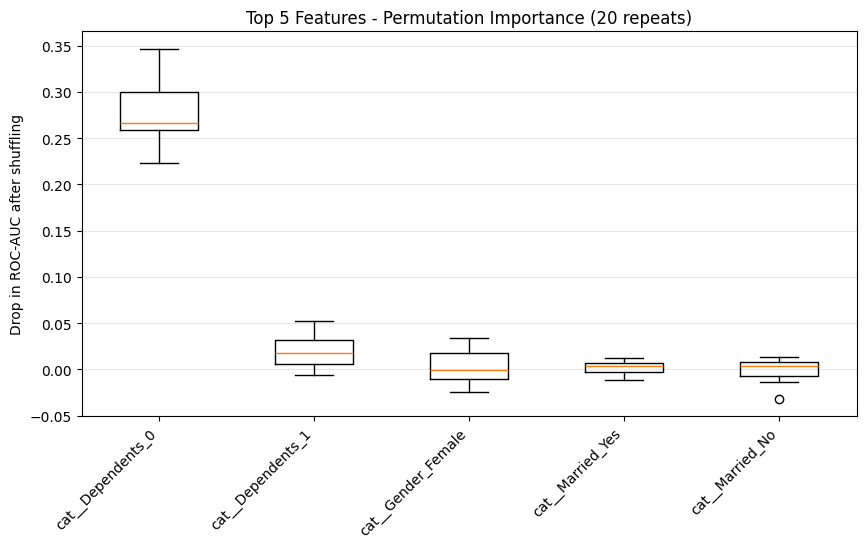

In [17]:

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

best_model = grid.best_estimator_

# Permutation importance on test set (20 repeats )
perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=20,
    random_state=42,
    scoring="roc_auc"
)

# Feature names after one-hot encoding
feat_names = best_model.named_steps["prep"].get_feature_names_out()

# Get average importance and sort
avg_imp = perm.importances_mean
sorted_idx = np.argsort(avg_imp)[::-1]

#  top 5 features
top5_idx = sorted_idx[:5]
top5_names = feat_names[top5_idx]

print("Top 5 features (permutation importance):")
for name, val in zip(top5_names, avg_imp[top5_idx]):
    print(f"{name}: {val:.4f}")

# Boxplot for top 5
plt.figure(figsize=(10,5))
plt.boxplot(perm.importances[top5_idx].T, tick_labels=top5_names)
plt.xticks(rotation=45, ha="right")
plt.title("Top 5 Features - Permutation Importance (20 repeats)")
plt.ylabel("Drop in ROC-AUC after shuffling")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

1) Dependents_0 is by far the most influential predictor. Shuffling this feature causes a large drop in ROC-AUC (0.27), indicating strong dependence of predictions on whether the applicant has no dependents.

2) Dependents_1 has a small but noticeable effect, suggesting the number of dependents impacts loan approval decisions.

3) Gender and marital status contribute minimally to the model’s performance.

4) The large gap between the first feature and the others suggests that dependency status is a primary driver in the model.

5) Some encoded variables ( Married_No) have near-zero importance, meaning the model does not rely on them significantly.

# Partial Dependence Plots (Top 5)

* I use Partial Dependence Plots (PDP) to understand how each of the top 5 features individually influences the model’s prediction. For each feature, I vary its value while keeping all other features constant and observe how the average predicted probability of loan approval changes. This helps interpret the model beyond just feature importance rankings

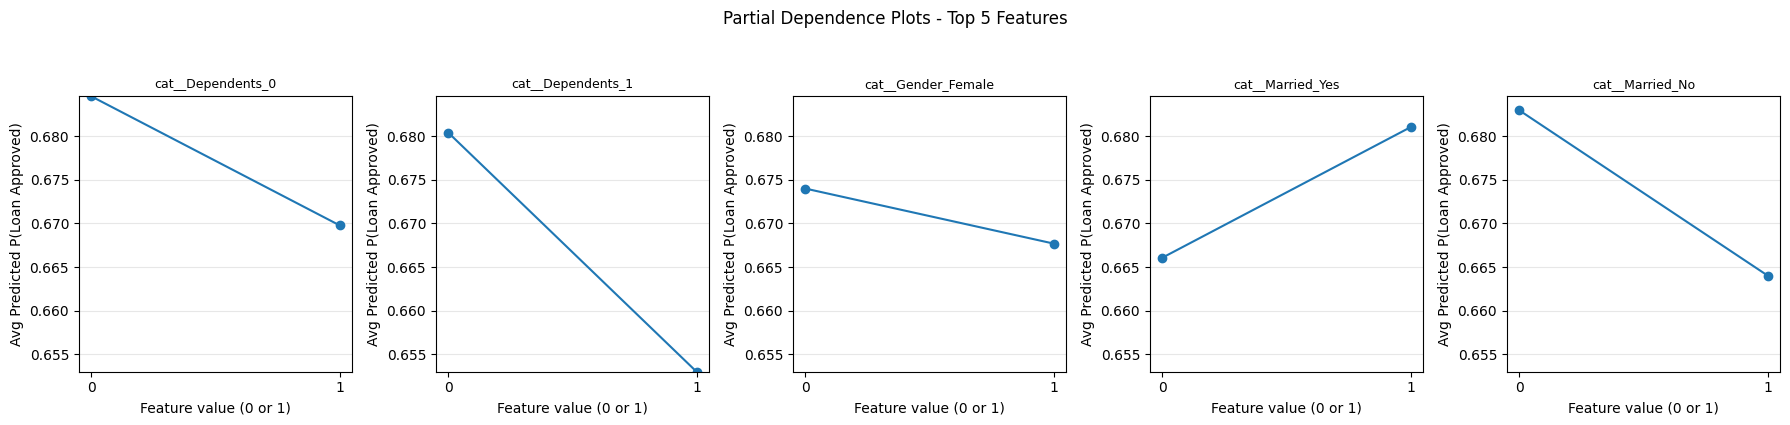

In [22]:

import numpy as np
import matplotlib.pyplot as plt

# Get the trained model from GridSearch
best_model = grid.best_estimator_

# Extract only the Random Forest part (already trained)
rf_model = best_model.named_steps["rf"]

# Apply the same preprocessing to the test set
# This converts categorical variables into numeric form
X_test_prep = best_model.named_steps["prep"].transform(X_test)

# Get feature names after one-hot encoding
feat_names = best_model.named_steps["prep"].get_feature_names_out()

# Convert to normal numpy array (in case it's sparse)
if hasattr(X_test_prep, "toarray"):
    X_base = X_test_prep.toarray()
else:
    X_base = np.array(X_test_prep)

# Since these are one-hot encoded features (0 or 1),
# we evaluate the model at two points: 0 and 1
grid_points = [0, 1]

# Compute average predicted probability when each feature is set to 0 and 1
pdp_values = {}

for idx in top5_idx:
    probs = []
    for val in grid_points:
        X_temp = X_base.copy()
        X_temp[:, idx] = val  # force feature to 0 or 1
        probs.append(rf_model.predict_proba(X_temp)[:, 1].mean())
    pdp_values[idx] = probs

# Find overall y-axis range so all plots use the same scale
all_y = [value for idx in top5_idx for value in pdp_values[idx]]
ymin = min(all_y)
ymax = max(all_y)

# Plot PDP for each of the top 5 features
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for ax, idx in zip(axes, top5_idx):
    ax.plot(grid_points, pdp_values[idx], marker="o")
    ax.set_title(feat_names[idx], fontsize=9)
    ax.set_xticks(grid_points)
    ax.set_xlabel("Feature value (0 or 1)")
    ax.set_ylabel("Avg Predicted P(Loan Approved)")
    ax.set_ylim(ymin, ymax)                                          # keeping  same Y-axis across all plots
    ax.grid(True, axis="y", alpha=0.3)

plt.suptitle("Partial Dependence Plots - Top 5 Features", y=1.05)
plt.tight_layout()
plt.show()

# Interpretation of Partial Dependence Plots

* The X-axis represents whether the feature is 0 or 1 (after one-hot encoding), while the Y-axis represents the average predicted probability of loan approval.

* For cat__Dependents_0, there is a noticeable change in predicted probability when the feature value changes, reinforcing its strong influence observed in permutation importance.

* For cat__Dependents_1, the probability decreases when set to 1, suggesting that having one dependent slightly reduces approval likelihood in the model.

* Gender and marital status features show relatively small changes in predicted probability, indicating weaker individual influence on predictions.

* Overall, the predicted probabilities remain within a relatively narrow range (0.65–0.69), suggesting that no single feature alone drastically shifts the model’s decision.

## Interestingly, income related variables such as ApplicantIncome and LoanAmount did not appear in the top 5, which is somewhat surprising since financial indicators are typically expected to influence loan approval decisions.